In [1]:
import pystan as ps
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


# used to force examples to run from local copy, rather than installed copy
import os, sys; sys.path.insert(0, os.path.abspath('../'))
import btom as bt

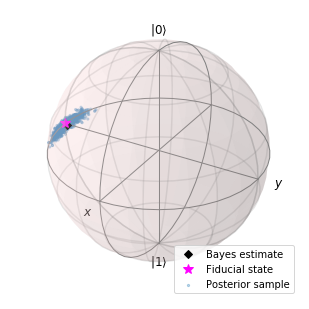

In [2]:
psi = np.array([[1],[-1j]])/np.sqrt(2)
rho = np.dot(psi, psi.conj().T)
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
data = bt.BinomialTomographyData.simulate(rho, meas_ops, [10,100,1000])

sampler = bt.BinomialGinibreStateSampler(ginibre_dim=1, n_chains=4)
pos = bt.StatePosterior(sampler, data)
pos.bloch_plot(fiducial_state=rho)

(2, 4)


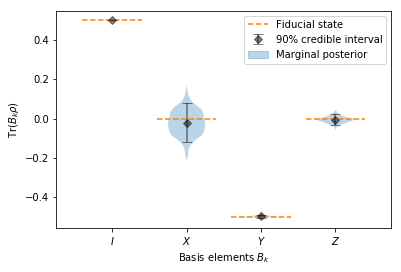

In [3]:
x = pos.basis_expansion_plot(bt.pauli_basis(), fiducial_state=rho)

In [4]:
x.get_alpha()

AttributeError: 'NoneType' object has no attribute 'get_alpha'

In [5]:
import matplotlib.patches as mp

In [8]:
a[0].get_color()

'#1f77b4'

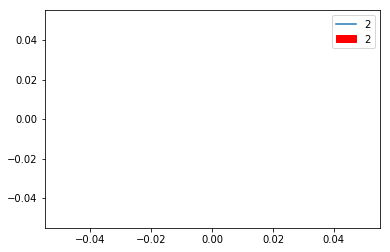

In [6]:
a = plt.plot(0,0, label='2')
leg = plt.legend()
p = mp.Patch(color='r', label='2')
leg.legendHandles.append(p)
leg.legendHandles
plt.legend(handles=leg.legendHandles)

In [8]:
leg.legendHandles

1.99 s ± 68.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


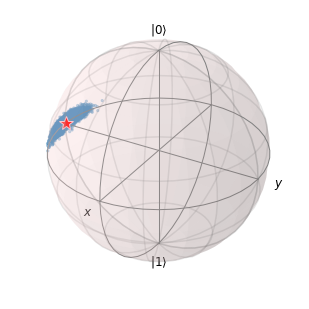

In [23]:
psi = np.array([[1],[-1j]])/np.sqrt(2)
rho = np.dot(psi, psi.conj().T)
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
data = bt.BinomialTomographyData.simulate(rho, meas_ops, [1000,1000,1000])

sampler = bt.BinomialGinibreStateSampler(ginibre_dim=1, n_chains=32)
%timeit pos = bt.StatePosterior(sampler, data)
pos.bloch_plot()

In [24]:
fit = pos._sampler._raw_sample(data.stan_data)

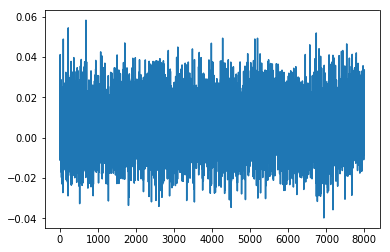

In [25]:
plt.plot(fit['rho_real'][:,1,0])

In [26]:
fit

Inference for Stan model: anon_model_c4669a608892f1022a0c9e61357dfc23.
32 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=8000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X_real[0,0]    -0.03    0.03   0.99  -1.73   -0.8  -0.11   0.79   1.79   1466   1.02
X_real[1,0]     0.03    0.03   1.03  -1.81  -0.81 4.3e-3   0.85   1.86   1326   1.02
X_imag[0,0]    -0.03    0.03   1.01  -1.83  -0.84-7.6e-4    0.8   1.78   1325   1.02
X_imag[1,0]    -0.03    0.03   1.01  -1.78  -0.81   -0.1    0.8   1.82   1466   1.02
rho_real[0,0]   0.49  1.4e-4   0.01   0.47   0.48   0.49    0.5   0.52   7798    1.0
rho_real[1,0] 6.5e-3  1.4e-4   0.01  -0.02-2.1e-3 6.8e-3   0.02   0.03   8000    1.0
rho_real[0,1] 6.5e-3  1.4e-4   0.01  -0.02-2.1e-3 6.8e-3   0.02   0.03   8000    1.0
rho_real[1,1]   0.51  1.4e-4   0.01   0.48    0.5   0.51   0.52   0.53   7798    1.0
rho_imag[0,0]    0.0     0.0    0.0    0.0    0.

In [15]:
m = bt.utils.StanModelFactory.load_builtin('ginibre-prior-real.stan').model

samples = m.sampling({'D':5, 'K': 5}, chains=32)

In [20]:
samples

Inference for Stan model: anon_model_11d132d0ad51a3f11092fed641d39b03.
32 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=32000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[0,0]   5.6e-3  5.6e-3   1.01  -1.95  -0.68 7.9e-3   0.69   1.99  32000    1.0
X[1,0]  -7.0e-3  5.6e-3    1.0  -1.97  -0.68-7.2e-3   0.67   1.96  32000    1.0
X[2,0]  -4.1e-3  5.6e-3   1.01  -1.98  -0.69 1.4e-3   0.69   1.95  32000    1.0
X[3,0]  -1.3e-3  5.6e-3    1.0  -1.94  -0.69-2.3e-3   0.67   1.96  32000    1.0
X[4,0]  -1.4e-3  5.6e-3   0.99  -1.95  -0.67-5.4e-3   0.66   1.96  32000    1.0
X[0,1]  -1.6e-3  5.7e-3   1.01  -1.97  -0.69 1.9e-3   0.68   1.97  32000    1.0
X[1,1]   1.5e-3  5.5e-3   0.99  -1.94  -0.67-4.9e-3   0.67   1.96  32000    1.0
X[2,1]   1.3e-3  5.6e-3    1.0  -1.96  -0.68 1.6e-3   0.68   1.96  32000    1.0
X[3,1]   1.6e-3  5.6e-3    1.0  -1.94  -0.67-5.3e-3   0.67   1.96  32000    1.0
X[4,1]  -

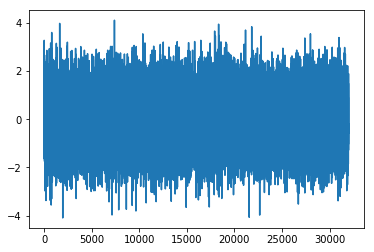

In [19]:
plt.plot(samples['X'][:,3,4])

In [13]:
meas_ops.dagger().dot(rho).trace()

array([1. +0.j, 0.5+0.j, 0.5+0.j])

In [3]:
%debug

> /home/ihincks/academics/research/projects/btom/btom/data.py(163)simulate()
    161         probs = StateTomographyData._measurement_results(meas_ops, true_state)
    162         if not np.allclose(np.imag(probs), 0):
--> 163             raise ValueError(('Some probabilities imaginary; check that'
    164                 'your measurements and state are positive semi-definite and '
    165                 'less than the identity'))

ipdb> probs
array([0.5+0.j , 0. +0.5j, 0. +0.j ])
ipdb> np.imag(probs)
array([0. , 0.5, 0. ])
ipdb> exit


In [4]:
def _set_labels(ax, labels, d='x'):
    if d == 'x':
        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
    elif d == 'y':
        ax.get_yaxis().set_tick_params(direction='out')
        ax.yaxis.set_ticks_position('bottom')
        ax.set_yticks(np.arange(1, len(labels) + 1))
        ax.set_yticklabels(labels)
        ax.set_ylim(0.25, len(labels) + 0.75)

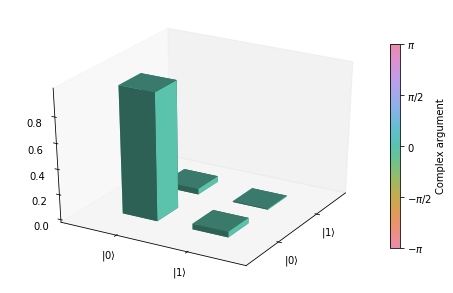

In [5]:
b = bt.canonical_basis(2)
bm = b.outer_product()
#pos._samples = np.array([[[1, 1j],[0.5 * 1j, 4 * np.exp(1j * np.pi)]]])
coeffs = bm.expansion(pos.states)
coeffs.shape

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as col
import matplotlib as mpl

# setup the figure and axes
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111, projection='3d')

# fake data
x = np.tile(np.arange(b.n_arrays),b.n_arrays) + 0.75
y = (np.arange(b.n_arrays)).repeat(b.n_arrays) + 0.75

top = np.mean(np.abs(coeffs), axis=1)
arg = np.mean(np.angle(coeffs), axis=1)
colors = bt.utils.complex_cmap(0.5 * (arg + np.pi) / np.pi)
bottom = np.zeros_like(top)
width = depth = 1


ax1.bar3d(x, y, bottom, 0.5, 0.5, top, shade=True, color=colors)

zaxis = ax1.zaxis
#draw_grid_old = zaxis.axes._draw_grid
# disable draw grid
zaxis.axes._draw_grid = False

tmp_planes = zaxis._PLANES

# draw zaxis on the left side
zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                 tmp_planes[0], tmp_planes[1],
                 tmp_planes[4], tmp_planes[5])

#olourMap = plt.cm.ScalarMappable(cmap=bt.utils.complex_cmap, norm=col.Normalize(-np.pi, np.pi))
#olourMap.set_array(arg)
#olBar = plt.colorbar(colourMap, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi]).set_label('Argument')
#colBar.set_labels((r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'))
cax, kw = mpl.colorbar.make_axes(ax1, shrink=.75, pad=.0)
cb = mpl.colorbar.ColorbarBase(cax, cmap=bt.utils.complex_cmap, norm=col.Normalize(-np.pi, np.pi), label='Complex argument')
cb.set_ticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
cb.set_ticklabels((r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'))


_set_labels(ax1, ['$' + name + '$' for name in b.names], 'x')
_set_labels(ax1, ['$' + name + '$' for name in b.names], 'y')

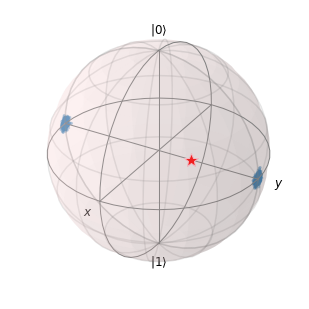

In [3]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=1)
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
data = bt.BinomialTomographyData(meas_ops, [1000,0,1000], [500,0,500])
pos = bt.StatePosterior(sampler, data)
a = pos.bloch_plot()

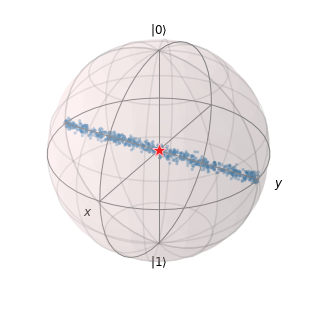

In [5]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=2)
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
data = bt.BinomialTomographyData(meas_ops, [5000,0,1000], [2500,0,500])
pos = bt.StatePosterior(sampler, data)
a = pos.bloch_plot()